In [61]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite as bi

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

import mplleaflet

from collections import OrderedDict 
from operator import getitem 

import math
import collections
from itertools import islice
from mpl_toolkits.basemap import Basemap as Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.Basemap'

In [2]:
#getting full list of businesses reviewed
busDF = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\business.json",lines=True)

In [3]:
#large number of reviews, reading in chunks
size = 1000000
review = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\review.json", lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

In [4]:
#then iterating through chunks
chunk_list = []
for chunk_review in review:
    #dropping fields out of scope for this study
    chunk_review = chunk_review.drop(['review_id','useful','funny','cool'], axis=1)
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    chunk_list.append(chunk_review)
revDF = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [5]:
#inspecting format of reviews table
revDF.head()

,user_id,business_id,review_stars,text,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5,I have to say that this office really has it t...,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [6]:
#following same process for Users data
users = pd.read_json(r"C:\Users\scohendevries\Documents\DATA620\yelp_dataset\user.json", lines=True,
                      dtype={'user_id':str,'name':str,
                             'review_count':int,'yelping_since':str,
                             'friends':list,'useful':int,'funny':int,
                             'cool':int,'fans':int,'elite':list,'average_stars':float,
                             'compliment_hot':int,'compliment_more':int,'compliment_profile':int,
                             'compliment_cute':int,'compliment_list':int,'compliment_note':int,
                             'compliment_plain':int,'compliment_cool':int,'compliment_funny':int,
                             'compliment_writer':int,'compliment_photos':int
                            },
                      chunksize=size
                     )

In [7]:
chunk_list = []
for chunk_review in users:
    chunk_review = chunk_review.drop(['yelping_since'
                                      ,'useful'
                                      ,'funny'
                                      ,'cool'
                                      ,'compliment_hot'
                                      ,'compliment_more'
                                      ,'compliment_profile'
                                      ,'compliment_cute'
                                      ,'compliment_list'
                                      ,'compliment_note'
                                      ,'compliment_plain'
                                      ,'compliment_cool'
                                      ,'compliment_funny'
                                      ,'compliment_writer'
                                      ,'compliment_photos'
                                     ], axis=1)
    chunk_list.append(chunk_review)
userDF = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

In [8]:
userDF.head()

,user_id,name,review_count,elite,friends,fans,average_stars
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03
1,4XChL029mKr5hydo79Ljxg,Jenna,33,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63
2,bc8C_eETBWL0olvFSJJd0w,David,16,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08


In [9]:
#pre-processed numbers from data set
print(str(len(busDF.index)) + ' businesses')
print(str(len(userDF.index)) + ' users')
print(str(len(revDF.index)) + ' reviews')

192609 businesses
1637138 users
6685900 reviews


In [10]:
#Grouping businesses by regions for greater numbers
regionDF = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
busDF = pd.merge(busDF,regionDF,how='inner',left_on='state',right_on='State Code')

In [11]:
busDF.groupby('Division').count()['business_id']

Division
East North Central    21783
East South Central        4
Middle Atlantic       11239
Mountain              93000
New England               5
Pacific                  24
South Atlantic        15890
West North Central        2
West South Central        7
Name: business_id, dtype: int64

In [12]:
#focus on single category
catDF = busDF.assign(categories = busDF.categories
                         .str.split(', ')).explode('categories')
catDF.categories.value_counts()

Restaurants          35878
Shopping             24260
Food                 19177
Home Services        18161
Health & Medical     14898
                     ...  
Entertainment Law        1
Customs Brokers          1
Slovakian                1
Oaxacan                  1
Backshop                 1
Name: categories, Length: 1273, dtype: int64

In [13]:
#further filtering data set by looking at top 5% by number of reviews
#for businesses I group by region to get samples from all regions, rather than skewing numbers towards densely populated areas
#however the original data is mostly centralized in four geographical divisions
busDF = busDF[busDF['categories'].str.contains('Restaurants|Shopping|Health',case=False,na=False)]
busDF['q'] = busDF.groupby(['Division'])['review_count'].rank(pct=True)
busDF = busDF[busDF['q'] > 0.99]
userDF = userDF[userDF.review_count > userDF.review_count.quantile(0.99)]

In [14]:
#in our filtered data set, we still see skewed numbers by state
#this is a function of the data set
print(str(len(busDF.index)) + ' businesses')
print(str(len(userDF.index)) + ' users')

busDF.groupby('Division').count()['business_id']

739 businesses
16365 users


Division
East North Central    127
East South Central      1
Middle Atlantic        65
Mountain              457
New England             1
Pacific                 1
South Atlantic         85
West North Central      1
West South Central      1
Name: business_id, dtype: int64

In [15]:
df = pd.merge(pd.merge(revDF,busDF,how='inner',on='business_id'),userDF,how='inner',on='user_id')

In [16]:
df = df[
    ['user_id'
     ,'business_id'
     ,'city'
     ,'state'
     ,'latitude'
     ,'longitude'
     ,'Region'
     ,'Division'
     ,'name_y'
     ,'review_stars'
     ,'stars'
     ,'average_stars'
     ,'categories'
     ,'text'
     ,'date']
]

In [17]:
#we need to limit the size of our final data set for Network Analysis and Text Processing
print(str(len(df.index)) + ' reviews')

101324 reviews


In [18]:
df = df.rename({'stars':'avgStars_biz'
           ,'average_stars':'avgStars_usr'
          }
         )

In [19]:
df.head(50)

,user_id,business_id,city,state,latitude,longitude,Region,Division,name_y,review_stars,stars,average_stars,categories,text,date
0,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,Las Vegas,NV,36.101449,-115.130511,West,Mountain,Carol,4,4.5,4.16,"Performing Arts, Amusement Parks, Museums, Arc...","Like walking back in time, every Saturday morn...",2011-11-30 02:11:15
1,FIk4lQQu1eTe2EpzQ4xhBA,Wxxvi3LZbHNIDwJ-ZimtnA,Las Vegas,NV,36.121189,-115.169657,West,Mountain,Carol,5,4.0,4.16,"Shopping Centers, Resorts, Arts & Entertainmen...","Love this place, walking into the front desk a...",2011-11-29 17:57:46
2,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",I love a good breakfast! And Bagel Cafe is def...,2010-12-11 13:34:01
3,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",Enjoy a simple breakfast with good service? th...,2014-11-03 18:27:08
4,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",This place is always good. Love the food. If b...,2017-01-10 05:32:10
5,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,4,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...","First time for lunch, it was about 130pm and i...",2012-10-27 04:48:49
6,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,5,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...","Always a crowd pleaser. We love the bagels, bu...",2010-10-18 03:55:20
7,FIk4lQQu1eTe2EpzQ4xhBA,FvVSy2r7_zDEhZWqLgjXNQ,Las Vegas,NV,36.176102,-115.260282,West,Mountain,Carol,4,4.0,4.16,"Breakfast & Brunch, Bagels, Delis, Coffee & Te...",Came in to pick up dessert! They have some rea...,2013-05-28 04:40:12
8,FIk4lQQu1eTe2EpzQ4xhBA,JyxHvtj-syke7m9rbza7mA,Las Vegas,NV,36.094457,-115.208867,West,Mountain,Carol,5,3.5,4.16,"Restaurants, Sushi Bars, Japanese","All you can eat sushi, but at a limit of one h...",2011-11-29 17:07:33
9,FIk4lQQu1eTe2EpzQ4xhBA,JyxHvtj-syke7m9rbza7mA,Las Vegas,NV,36.094457,-115.208867,West,Mountain,Carol,4,3.5,4.16,"Restaurants, Sushi Bars, Japanese","This is our second time here, again an AYCE su...",2012-03-22 16:35:12


In [20]:
stopWords = set(stopwords.words('english'))

In [21]:
#using nltk to filter out stopwords, numbers and punctuation
def nonStops(text):
    return [word for word in word_tokenize(text) \
            if word.lower() not in stopWords \
            and not word.isdigit()\
            and word.isalpha()
           ]

In [22]:
byReg = {}
allWords = {}
for i in df.itertuples():
    t = nonStops(i.text)
    #leveling weights here, so that a review score of 3 is seen as neutral, and anything above/below is positive/negative
    revWt = i.review_stars - 3
    #creating a dictionary of all words to differentiate weighting by region
    for w in t:
        if w not in allWords.keys():
            allWords[w] = {'n':1,'wt':revWt,'mean':revWt,'stDev':0}
        else:
            allWords[w]['n'] += 1
            allWords[w]['wt'] += revWt
            allWords[w]['mean'] = allWords[w]['wt']/allWords[w]['n']
        if w not in byReg.keys():
            byReg[w] = {}
        if i.Division not in byReg[w].keys():
            byReg[w][i.Division] = {'n':1,'wt':revWt,'mean':revWt}
        else:
            byReg[w][i.Division]['n'] += 1
            byReg[w][i.Division]['wt'] += revWt
            byReg[w][i.Division]['mean'] = byReg[w][i.Division]['wt']/byReg[w][i.Division]['n']

In [23]:
for i in allWords.keys():
    mn = allWords[i]['wt']/allWords[i]['n']
    sdn = 0
    n = 0
    for j in byReg[i].keys():
        sdn += byReg[i][j]['mean'] - mn
        n += 1
    sd = (sdn**2.0)/(n)
    allWords[i]['stDev'] = sd

In [24]:
byReg

{'Like': {'Mountain': {'n': 1540, 'wt': 1203, 'mean': 0.7811688311688312},
  'East North Central': {'n': 91, 'wt': 72, 'mean': 0.7912087912087912},
  'West South Central': {'n': 5, 'wt': 8, 'mean': 1.6},
  'Middle Atlantic': {'n': 73, 'wt': 67, 'mean': 0.9178082191780822},
  'South Atlantic': {'n': 92, 'wt': 62, 'mean': 0.6739130434782609}},
 'walking': {'Mountain': {'n': 2967, 'wt': 2158, 'mean': 0.7273340074148972},
  'East North Central': {'n': 102, 'wt': 93, 'mean': 0.9117647058823529},
  'Middle Atlantic': {'n': 105, 'wt': 90, 'mean': 0.8571428571428571},
  'South Atlantic': {'n': 108, 'wt': 83, 'mean': 0.7685185185185185},
  'West South Central': {'n': 1, 'wt': 2, 'mean': 2}},
 'back': {'Mountain': {'n': 29478, 'wt': 24137, 'mean': 0.8188140308026325},
  'East North Central': {'n': 1922, 'wt': 1878, 'mean': 0.9771071800208116},
  'West South Central': {'n': 50, 'wt': 59, 'mean': 1.18},
  'Middle Atlantic': {'n': 1409, 'wt': 1275, 'mean': 0.9048970901348474},
  'South Atlantic': {

In [25]:
allWords

{'Like': {'n': 1801,
  'wt': 1412,
  'mean': 0.7840088839533592,
  'stDev': 0.14248558806748945},
 'walking': {'n': 3283,
  'wt': 2426,
  'mean': 0.7389582698751143,
  'stDev': 0.4929603686536009},
 'back': {'n': 34611,
  'wt': 28790,
  'mean': 0.8318164745312184,
  'stDev': 0.059236064061491144},
 'time': {'n': 45508,
  'wt': 40756,
  'mean': 0.8955787993319856,
  'stDev': 0.006885771850650006},
 'every': {'n': 10392,
  'wt': 12119,
  'mean': 1.1661855273287145,
  'stDev': 0.04098145879709569},
 'Saturday': {'n': 3745,
  'wt': 3382,
  'mean': 0.9030707610146862,
  'stDev': 0.004941090550515978},
 'morning': {'n': 3795,
  'wt': 3336,
  'mean': 0.8790513833992095,
  'stDev': 0.09479986501861938},
 'sister': {'n': 1345,
  'wt': 1208,
  'mean': 0.8981412639405204,
  'stDev': 0.19792934454864178},
 'bowling': {'n': 271,
  'wt': 296,
  'mean': 1.0922509225092252,
  'stDev': 0.012469856501969098},
 'league': {'n': 50, 'wt': 48, 'mean': 0.96, 'stDev': 1.4234762471655331},
 'done': {'n': 5141,

In [26]:
#in order to find words which might have their sentiment vary by region, we find those with the most volatility in terms of related review scores
topsd_dict = OrderedDict(sorted(allWords.items(),key = lambda x: getitem(x[1], 'stDev'),reverse=True))
top10 = list(islice(topsd_dict, 100))[:10]

In [27]:
#looking at sample reviews for one of the more voltile words
textDF = pd.DataFrame()
for i in top10:
    stgDF = pd.DataFrame(df[df['text'].str.contains(i)][['Division','review_stars','text']])
    stgDF['word'] = i
    textDF = pd.concat([textDF,stgDF])
textDF

,Division,review_stars,text,word
2080,Mountain,3,I feel like I came in on an off night. \n\nThi...,Tail
3486,Mountain,4,"""I just want to begin by saying to Roosevelt E...",Tail
3756,Mountain,5,"Return on Investment, Creating Community or wh...",Tail
3785,East North Central,2,Items Selected:\nSausage and Pepperoni Pizza\n...,Tail
3821,Mountain,1,"Being completely honest, I'm usually not a fan...",Tail
...,...,...,...,...
90024,Mountain,3,"As a fan of all things Gordon Ramsey, we decid...",Goodbye
92183,Mountain,1,James Brown is dead. And so is Tao.\n\nWe cam...,Goodbye
94531,Mountain,5,Excellent service by Juice and Keith. Gotta h...,Goodbye
96729,Mountain,4,Something different from the pretentious* upsc...,Goodbye


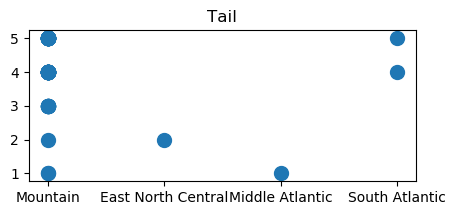

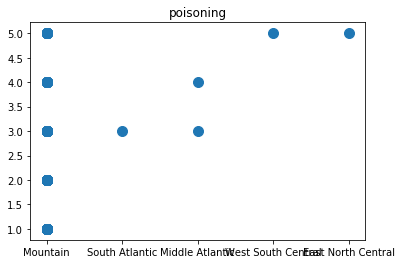

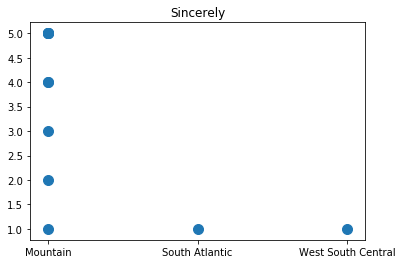

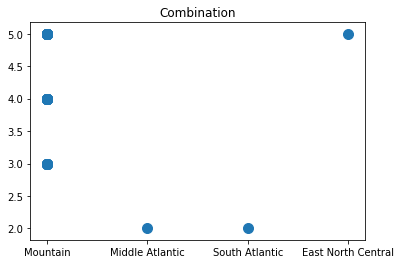

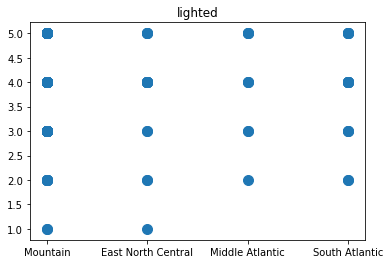

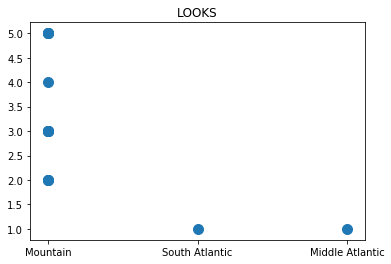

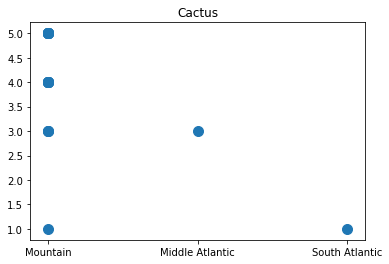

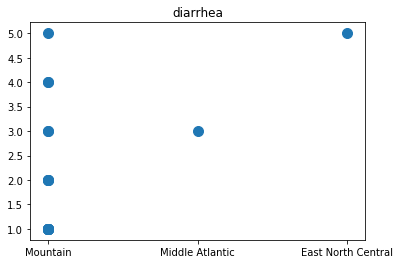

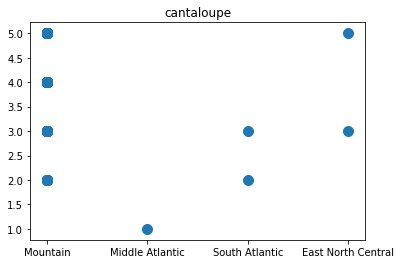

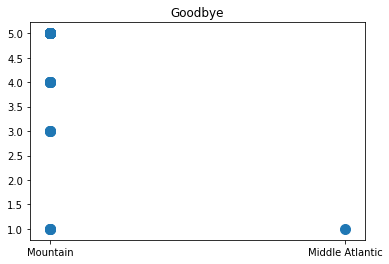

In [28]:
#norm = plt.Normalize(1,25)
#cmap = plt.cm.RdYlGn

#fig,ax = plt.subplots()
fig=plt.figure(figsize=(5,2), dpi= 100, facecolor='w', edgecolor='k')
for w in top10:
    plt.scatter(textDF[textDF['word']==w]['Division']
                ,textDF[textDF['word']==w]['review_stars']
                ,s=100
               )
    plt.title(w)
    plt.show()

In [29]:
#The second part of the analysis involves a network analysis of business, based on patrons
usr = df['user_id'].values.tolist()
biz = df['business_id'].values.tolist()

g=nx.from_pandas_edgelist(df,'user_id','business_id',['city','state','latitude','longitude'])

print(len(g))

13475


In [30]:
#creating a bipartite graph with Businesses as the top node
bNet = bi.weighted_projected_graph(g, biz)

In [31]:
for i in sorted(nx.connected_components(bNet), key = len, reverse=True)[0:20]:
    print(len(i))

736


In [32]:
#Defining a set of functions to utilize the island method for network analysis
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,weight=edata['weight'])
    return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

def sorted_map(d):
    ms = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return ms

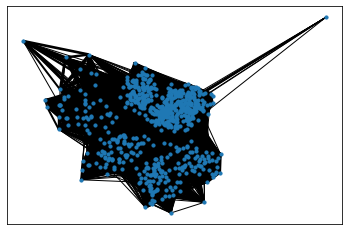

In [137]:
bweights=[math.sqrt(edata['weight']) for f,t,edata in bNet.edges(data=True)]
nx.draw_networkx(bNet
                 , width=bweights
                 , node_size=10
                 , with_labels=False)

(array([1.35133e+05, 1.77200e+03, 2.85000e+02, 8.80000e+01, 3.20000e+01,
        9.00000e+00, 9.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([  1. ,  40.7,  80.4, 120.1, 159.8, 199.5, 239.2, 278.9, 318.6,
        358.3, 398. ]),
 <a list of 10 Patch objects>)

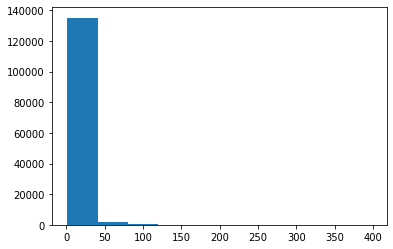

In [34]:
plt.hist(bweights)

In [140]:
btwn = nx.betweenness_centrality(bnet_trim)
sizes = [btwn[i]*10000 for i in bnet_trim.nodes]
state_dict = busDF[['business_id','state']].set_index('business_id')[['state']].T.apply(tuple).to_dict()
labels = [state_dict[biz] for biz in state_dict.keys()]

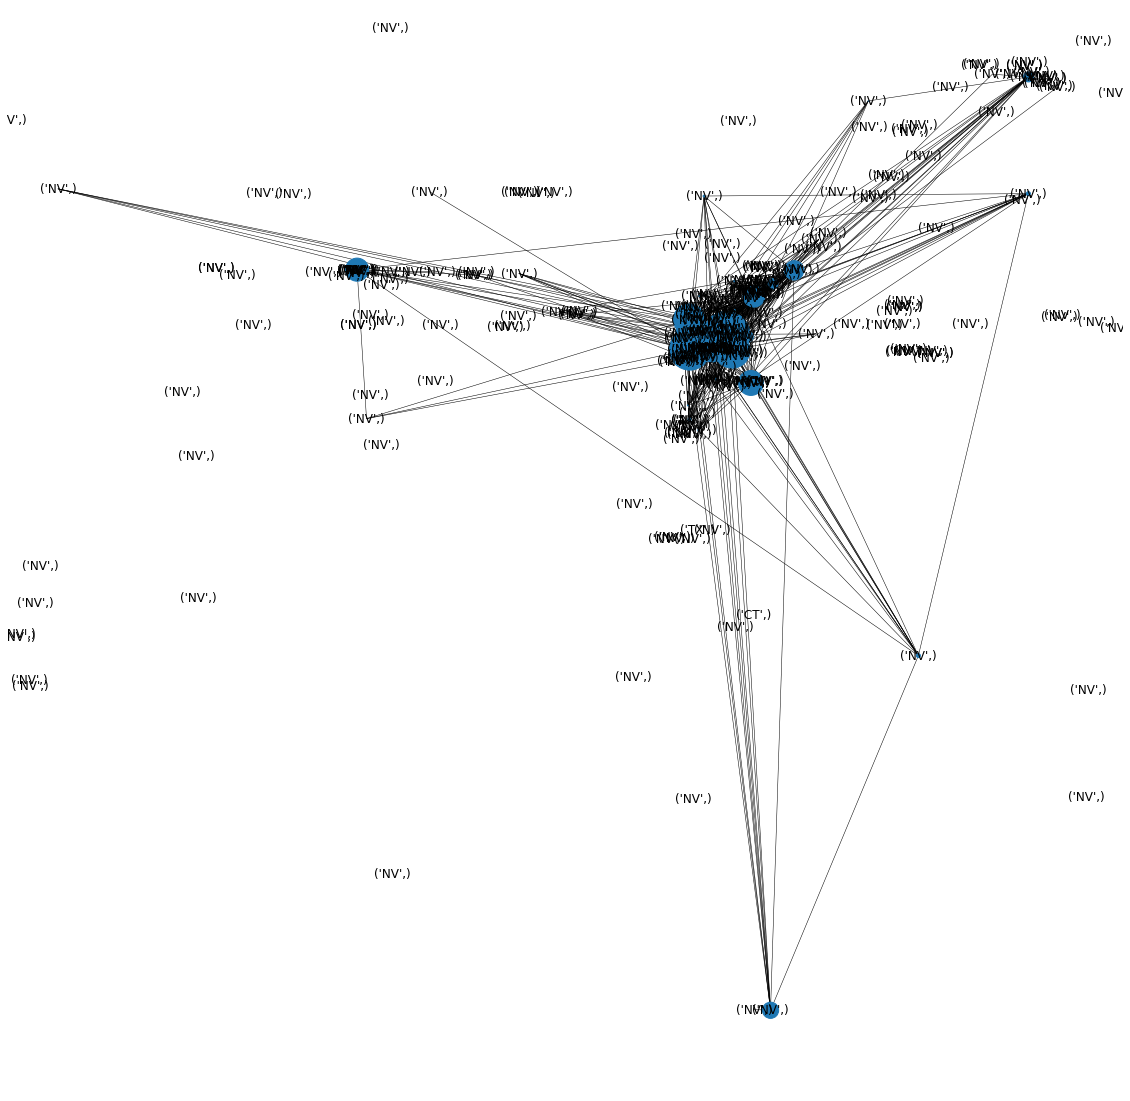

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
bnet_trim=trim_edges(bNet, weight=75)
weights=[math.log(edata['weight']) for f,t,edata in bnet_trim.edges(data=True)]
nx.draw_networkx(bnet_trim
                 ,pos=pos
                 ,ax=ax
                 ,width=.5
                 , node_size=sizes
                 , with_labels=True
                 ,labels = state_dict
                )
ax.set_axis_off()

In [106]:
for i in g.nodes():
    #cities[i] = g.node[i]['city']
    print(g[i])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'XXW_OFaYQkkGOGniujZFHg': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1336673317, 'longitude': -115.1630947555}, '4JNXUYY8wbaaDmk3BPzlWw': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.112859, 'longitude': -115.172434}, 'nVAJZ6BJ9PPlxDXn976R6A': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1013195, 'longitude': -115.1821862}}
{'XXW_OFaYQkkGOGniujZFHg': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1336673317, 'longitude': -115.1630947555}, 'vl2IZrNJEA8npSjqXbdwxw': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.204189, 'longitude': -115.260244}, 'RhEvP5flF6KoPriMHmVYGg': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1564126328, 'longitude': -115.3328468966}, 'ajoqEHnCZTD8-8GqGLq9-Q': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1144832, 'longitude': -115.1948136}, '6Q7-wkCPc1KF75jZLOTcMw': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1376416, 'longitude': -115.1653861}, '3xmfT7l3xNH5LK1dLzfvGw': {'city': 'Las Vegas', 'state': 'NV', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}, '2weQS-RnoOBhb1KsHKyoSQ': {'city': 'Las Vegas', 'state': 'NV', 'latitude': 36.1268872232, 'longitude': -115.1655900478}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491602, 'longitude': -112.0656345}}
{'pSQFynH1VxkfSmehRXlZWw': {'city': 'Phoenix', 'state': 'AZ', 'latitude': 33.4491

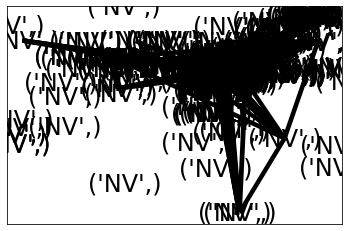

In [127]:
#fig = plt.figure()
bPos = busDF[['business_id','longitude','latitude']].set_index('business_id')[['longitude','latitude']].T.apply(tuple)
pos = bPos.to_dict()
nx.draw_networkx(bnet_trim
                 , pos
                 , with_labels=True
                 , node_size=sizes
                 , labels=state_dict
                 , font_size=24
                 , width=weights
                )
#nx.draw_networkx_labels(bnet_trim,pos,nx.get_node_attributes(g,'city'),font_size=16,font_color='b')
#mplleaflet.display(fig=fig) 

In [56]:
btwn

{'Wxxvi3LZbHNIDwJ-ZimtnA': 0.04593701629423061,
 '5LNZ67Yw9RD6nf4_UhXOjw': 0.06979865483270684,
 'ii8sAGBexBOJoYRFafF9XQ': 0.009395653859720023,
 'eAc9Vd6loOgRQolMXQt6FA': 0.0002646893624337233,
 '2weQS-RnoOBhb1KsHKyoSQ': 0.03738804398058782,
 '3xmfT7l3xNH5LK1dLzfvGw': 0.00988047596502487,
 'AV6weBrZFFBfRGCbcRGO4g': 9.061910975786574e-05,
 'f4x1YBxkLrZg652xt2KR5g': 0.0003970809891862524,
 '4JNXUYY8wbaaDmk3BPzlWw': 0.21459458536064616,
 'eoHdUeQDNgQ6WYEnP2aiRw': 0.010485658763707712,
 'DfgZlNgKwBvCpA_0alumXw': 5.735890903355019e-05,
 'rcaPajgKOJC2vo_l3xa42A': 0.014215645806734773,
 'K7lWdNUhCbcnEvI0NhGewg': 0.1677432904418624,
 'NvKNe9DnQavC9GstglcBJQ': 0.0012785625770601935,
 'XZbuPXdyA0ZtTu3AzqtQhg': 0.0004056609409705069,
 '3uC7Lbc3RgUDTWQlBu4PqQ': 0.0,
 'NCFwm2-TDb-oBQ2medmYDg': 5.476979161189687e-05,
 'DkYS3arLOhA8si5uUEmHOw': 0.1288866720789124,
 'ECOkEVUodMLUxvI0PMI4gQ': 0.0008086752618536624,
 'uGupeWqih0yIcCg8anM1PA': 0.010249979691376244,
 'Az_60nNuh1FH8Ds8oasZjw': 0.0,
 'XXW_

In [37]:
#top connected businesses could be interpreted as "tourist" centers, in that they represent places of business which are
#reviews by patrons who review/patronize other businesses (presumably in other areas)
top_biz = []
for i in sorted_map(btwn)[:20]:
    top_biz.append(i[0])
busDF[busDF['business_id'].isin(top_biz)]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,State,State Code,Region,Division,q
71789,ujHiaprwCQ5ewziu0Vi9rw,The Buffet at Bellagio,3600 S Las Vegas Blvd,Las Vegas,NV,89109,36.113220,-115.176890,3.5,4227,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","American (New), Buffets, Restaurants","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Nevada,NV,West,Mountain,0.999803
71913,Wxxvi3LZbHNIDwJ-ZimtnA,The Venetian Las Vegas,3355 South Las Vegas Boulevard,Las Vegas,NV,89109,36.121189,-115.169657,4.0,3499,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Shopping Centers, Resorts, Arts & Entertainmen...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",Nevada,NV,West,Mountain,0.999628
77023,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,"3708 Las Vegas Blvd S, Level 3, The Boulevard ...",Las Vegas,NV,89109,36.109837,-115.174212,4.0,4286,1,"{'RestaurantsPriceRange2': '1', 'BikeParking':...","Pizza, Restaurants","{'Monday': '11:0-5:0', 'Tuesday': '11:0-4:0', ...",Nevada,NV,West,Mountain,0.999825
77531,UPIYuRaZvknINOd1w8kqRQ,Monta Ramen,"5030 Spring Mountain Rd, Ste 6",Las Vegas,NV,89146,36.127034,-115.209819,4.0,2604,1,"{'OutdoorSeating': 'False', 'Alcohol': 'u'beer...","Noodles, Ramen, Restaurants, Japanese","{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",Nevada,NV,West,Mountain,0.999234
78112,K7lWdNUhCbcnEvI0NhGewg,Wicked Spoon,3708 Las Vegas Blvd S,Las Vegas,NV,89109,36.109550,-115.176155,3.5,6708,1,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Buffets, Breakfast & Brunch, Restaurants","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",Nevada,NV,West,Mountain,0.999956
81118,P7pxQFqr7yBKMMI2J51udw,Holsteins,"3708 Las Vegas Blvd S, Level 2, Boulevard Tower",Las Vegas,NV,89109,36.109842,-115.174603,4.0,3159,1,"{'OutdoorSeating': 'False', 'WiFi': 'u'free'',...","Nightlife, Bars, Burgers, Restaurants, America...","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",Nevada,NV,West,Mountain,0.999409
81803,LNGBEEelQx4zbfWnlc66cw,Studio B Buffet,12300 Las Vegas Blvd S,Henderson,NV,89044,35.965072,-115.167980,4.0,2241,1,"{'BikeParking': 'False', 'NoiseLevel': 'u'aver...","Restaurants, Seafood, Desserts, Specialty Food...","{'Monday': '11:0-20:30', 'Tuesday': '11:0-20:3...",Nevada,NV,West,Mountain,0.998796
83337,rcaPajgKOJC2vo_l3xa42A,Bouchon,"3355 Las Vegas Blvd S, Venezia Tower, 10th floor",Las Vegas,NV,89109,36.120955,-115.169853,4.0,3859,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","French, Bars, Cocktail Bars, Nightlife, Breakf...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",Nevada,NV,West,Mountain,0.999694
86961,4JNXUYY8wbaaDmk3BPzlWw,Mon Ami Gabi,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112859,-115.172434,4.0,8348,1,"{'Corkage': 'True', 'RestaurantsDelivery': 'Fa...","Food, French, Breakfast & Brunch, Restaurants,...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",Nevada,NV,West,Mountain,1.000000
87278,DkYS3arLOhA8si5uUEmHOw,Earl of Sandwich,3667 Las Vegas Blvd S,Las Vegas,NV,89109,36.109418,-115.171874,4.5,5075,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Food Delivery Services, Salad, Sandwiches, Sou...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",Nevada,NV,West,Mountain,0.999891


In [ ]:
"""
https://towardsdatascience.com/converting-yelp-dataset-to-csv-using-pandas-2a4c8f03bd88
"""